In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Load dataset ===
train_ds = image_dataset_from_directory(
    "../dataset/",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    "../dataset/",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)

class_names = train_ds.class_names
print("Class names:", class_names)
# Expected: ['Cape Sparrow', 'Cape White-eye', 'Masked weaver', 'Squirrel', 'Swee Waxbill']
swee_index = class_names.index("Swee Waxbill")


Found 26427 files belonging to 5 classes.
Using 21142 files for training.
Found 26427 files belonging to 5 classes.
Using 5285 files for validation.
Class names: ['Cape Sparrow', 'Cape White-eye', 'Masked Weaver', 'Squirrel', 'Swee Waxbill']


In [4]:
# === Step 2: Define augmentation and normalization ===
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])

normalization_layer = tf.keras.layers.Rescaling(1./255)

In [5]:
# === Step 3: Custom preprocessing to apply more augmentation for Swee Waxbill ===
def custom_preprocess(x, y):
    x = normalization_layer(x)
    # Apply heavier augmentation to Swee Waxbill class
    is_swee = tf.equal(y, swee_index)
    x_augmented = data_augmentation(x, training=True)
    x_augmented = tf.where(is_swee[:, tf.newaxis, tf.newaxis, tf.newaxis], 
                           data_augmentation(x_augmented, training=True), 
                           x_augmented)
    return x_augmented, y

train_ds = train_ds.map(custom_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
# === Step 4: Performance optimizations ===
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [7]:
# === Step 5: Build the model ===
model = models.Sequential([
    layers.Input(shape=(256, 256, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(5, activation='softmax')  # Updated for 5 species
])

model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,235,013 (50.49 MB)

 Trainable params: 13,235,013 (50.49 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# === Step 6: Calculate class weights ===
# Based on known image counts: 5500 for all, 4500 for Swee Waxbill
image_counts = [5500, 5500, 5500, 5500, 4427]  # Match class_names order
labels = []
for i, count in enumerate(image_counts):
    labels.extend([i] * count)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=np.array(labels)
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.9609818181818182), 1: np.float64(0.9609818181818182), 2: np.float64(0.9609818181818182), 3: np.float64(0.9609818181818182), 4: np.float64(1.1939010616670431)}


In [9]:

# === Step 7: Fit the model ===
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

Epoch 1/40
661/661 ━━━━━━━━━━━━━━━━━━━━ 2275s 3s/step - accuracy: 0.3631 - loss: 1.5953 - val_accuracy: 0.6057 - val_loss: 1.1804
Epoch 2/40
661/661 ━━━━━━━━━━━━━━━━━━━━ 1803s 3s/step - accuracy: 0.6239 - loss: 1.1531 - val_accuracy: 0.6738 - val_loss: 1.0669
Epoch 3/40
661/661 ━━━━━━━━━━━━━━━━━━━━ 1808s 3s/step - accuracy: 0.6850 - loss: 1.0224 - val_accuracy: 0.7043 - val_loss: 0.9843
Epoch 4/40
661/661 ━━━━━━━━━━━━━━━━━━━━ 1805s 3s/step - accuracy: 0.7082 - loss: 0.9529 - val_accuracy: 0.7114 - val_loss: 0.9903
Epoch 5/40
661/661 ━━━━━━━━━━━━━━━━━━━━ 1804s 3s/step - accuracy: 0.7396 - loss: 0.9153 - val_accuracy: 0.6906 - val_loss: 1.0294
Epoch 6/40
661/661 ━━━━━━━━━━━━━━━━━━━━ 1808s 3s/step - accuracy: 0.7504 - loss: 0.8779 - val_accuracy: 0.7306 - val_loss: 0.9899
Epoch 7/40
661/661 ━━━━━━━━━━━━━━━━━━━━ 1811s 3s/step - accuracy: 0.7742 - loss: 0.8435 - val_accuracy: 0.7372 - val_loss: 0.9745
Epoch 8/40
661/661 ━━━━━━━━━━━━━━━━━━━━ 1804s 3s/step - accuracy: 0.7865 - loss: 0.8116 - 

In [10]:
# === Step 8: Save model ===
model.save("5_Species_cnn_2025_07_26.keras")

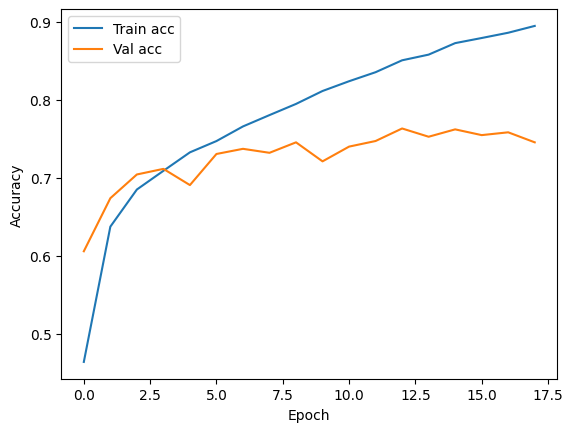

In [11]:
# === Step 9: Plot accuracy ===
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
